# Semantic Segmentation with UNet

This Kaggle notebook explores semantic segmentation using a UNet architecture. Semantic segmentation involves classifying each pixel in an image to a specific category, providing a detailed understanding of the image's content. In this notebook, we focus on flood area segmentation as an application.

## Dataset
The dataset consists of images and corresponding masks representing flood areas. The images and masks are loaded using a custom dataset class, and transformations are applied for preprocessing.

## Model Architecture
The semantic segmentation model is built using a UNet architecture. The model is trained with a Dice Loss and Adam optimizer.

The classical U-Net architecture is shown below. In this architecture.

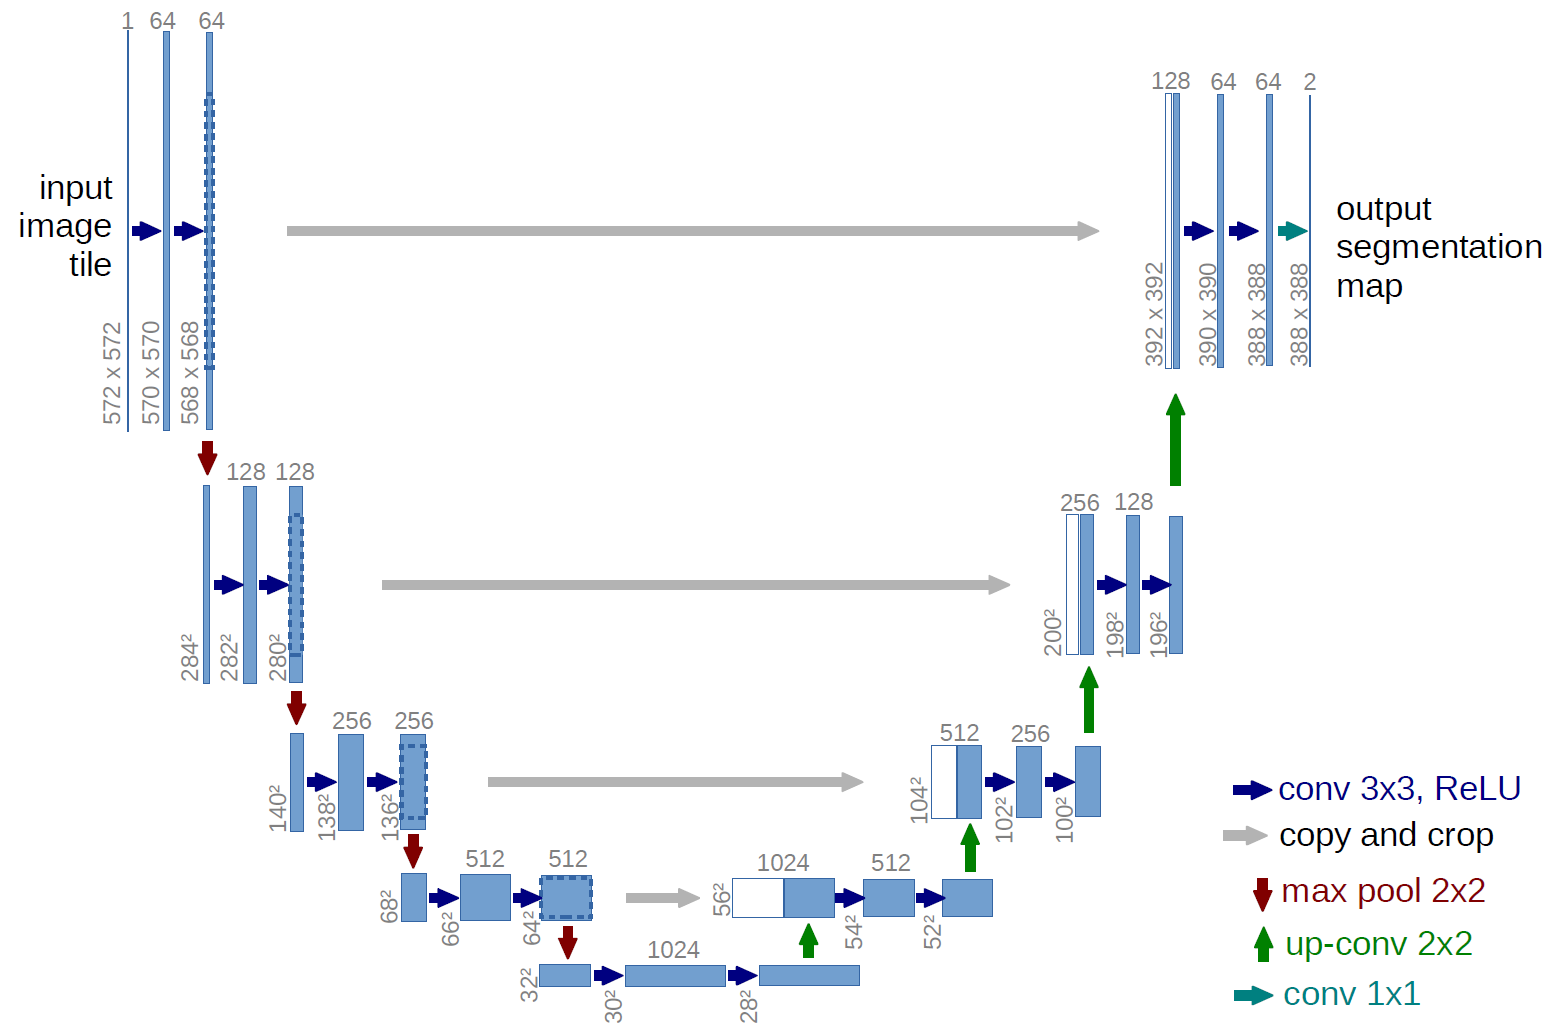


## Training and Evaluation
The notebook includes functions for training the model, visualization of training samples, and evaluation metrics computation. Early stopping is employed to prevent overfitting.

## Results
The trained model is loaded, and examples from the validation and test sets are visualized. Metrics such as accuracy, IoU, F1 score, precision, and recall are computed for assessing the model's performance.

## Import necessary libraries for image processing, deep learning, and visualization

In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp


In [21]:
main_directory_path = 'D:\\Technion\\ProjectDeepLearning\\Eyal1\\FloodAreaSegmentation'

import sys
import os
sys.path.append(main_directory_path)

from scripts.utils import get_processed_images_and_masks, get_augmented_images_and_masks

In [22]:
torch.cuda.empty_cache()

## Define Constants and Seed

In [23]:
IMAGE_DIR = "archive/Image/"
MASK_DIR = "archive/Mask/"

BATCH_SIZE = 8//2            # small to avoid vague faces/backgrounds
PATCH_SIZE = (256, 256)   # size of the patches

TENSOR_BOARD_BASE   = 'TB'

torch.manual_seed(42)     # Set a global random seed for reproducibility

## Define Custom Dataset Class

In [24]:
class FloodAreaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None, augmentations=None):
        self.img_labels = sorted([file for file in os.listdir(image_dir)])
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        mask_path = os.path.join(self.mask_dir, self.img_labels[idx]).replace(".jpg", ".png")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augmentations:
            image, mask = self.augmentations(image, mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.long()

## Define Image and Mask Transformations

In [25]:
image_transform = transforms.Compose([
    transforms.Resize(size=PATCH_SIZE, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=PATCH_SIZE, antialias=False)
])

# train_augmentations = transforms.Compose([
#     transforms.RandomVerticalFlip(),
# ])

In [26]:
processed_images, processed_masks = get_processed_images_and_masks()
IMAGE_DIR = os.path.dirname(processed_images[0])
MASK_DIR = os.path.dirname(processed_masks[0])

print(IMAGE_DIR, MASK_DIR)

../data/raw/images ../data/raw/masks


## Create Dataset and DataLoader Instances

In [27]:
# Define the dataset
dataset = FloodAreaDataset(IMAGE_DIR, MASK_DIR, image_transform=image_transform, mask_transform=mask_transform)

# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))

# train_dataset.augmentations = train_augmentations

# Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define Functions for Denormalization and Visualization

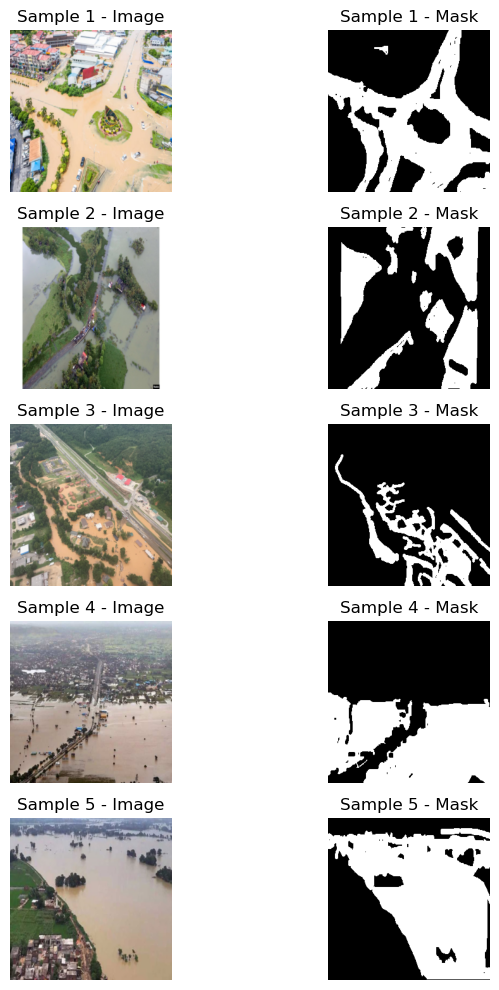

In [28]:
# Function to denormalize images
def denormalize_tensor(image, mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Function to visualize images and masks
def visualize_samples(dataset, num_samples=5):
    # Visualize the images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        
        # Display images
        axes[i, 0].imshow(denormalize_tensor(image).cpu().permute(1,2,0))
        axes[i, 0].imshow((image).cpu().permute(1,2,0))
        axes[i, 0].set_title(f'Sample {i + 1} - Image')
        axes[i, 0].axis('off')

        # Display masks
        axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Sample {i + 1} - Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset)

## Define UNet++ Model

In [29]:
# Define the model
model_unet_plus_plus = smp.UnetPlusPlus(
    encoder_name='resnet34', 
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None, 
    in_channels=3, 
    classes=1, 
    activation=None, 
    aux_params=dict(
        pooling='max',             # one of 'avg', 'max'
        dropout=0.1,               # dropout ratio, default is None
        activation='sigmoid',      # activation function, default is None
        classes=1,                 # define number of output labels
    )
)

## Instantiate Model

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_unet_plus_plus = model_unet_plus_plus.to(device)


## Define Training Constants and Initialize Early Stopping Parameters

In [31]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = 20

# Define the loss function, optimizer, and learning rate scheduler
# criterion = smp.losses.DiceLoss('multiclass')
# criterion = nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model_unet_plus_plus.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

d:\Technion\envs\FloodSegProg\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [32]:
import torchinfo
torchinfo.summary(model_unet_plus_plus)

Layer (type:depth-idx)                        Param #
UnetPlusPlus                                  --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    │    └─BasicBlock: 3-3                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   230,144
│    │    └─BasicBlock: 3-5                   295,424
│    │    └─BasicBlock: 3-6                   295,424
│    │    └─BasicBlock: 3-7                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   919,040
│    │    └─BasicBlock: 3-9                   1,180,672
│    │    └─Basi

## Plot Examples Function

In [33]:
import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F

# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.inference_mode():
            output= model(image.unsqueeze(0).to(device))
        if isinstance(output, tuple):
                output = output[0].squeeze(0).to('cpu')

        probabilities = F.sigmoid(output)
        pred_mask = (probabilities > 0.5).float()  # Convert probabilities to binary mask
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(denormalize_tensor(image).permute(1,2,0))
        # plt.imshow((image).permute(1,2,0))
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

## Train the model

In [34]:
# Define the Writer
example_input = torch.randn(BATCH_SIZE, 3, 512, 512)  # Modify this based on your model's input requirements
print(example_input.shape)

# Move the example input to the same device as the model
device = next(model_unet_plus_plus.parameters()).device
example_input = example_input.to(device)

oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'unet++_graph'))
oTBWriter.add_graph(model_unet_plus_plus, example_input) #<! Graph of the Model
oTBWriter.close()

torch.Size([4, 3, 512, 512])


d:\Technion\envs\FloodSegProg\Lib\site-packages\segmentation_models_pytorch\base\model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Epoch [1/50], Train Loss: 0.2737, Validation Loss: 0.2531


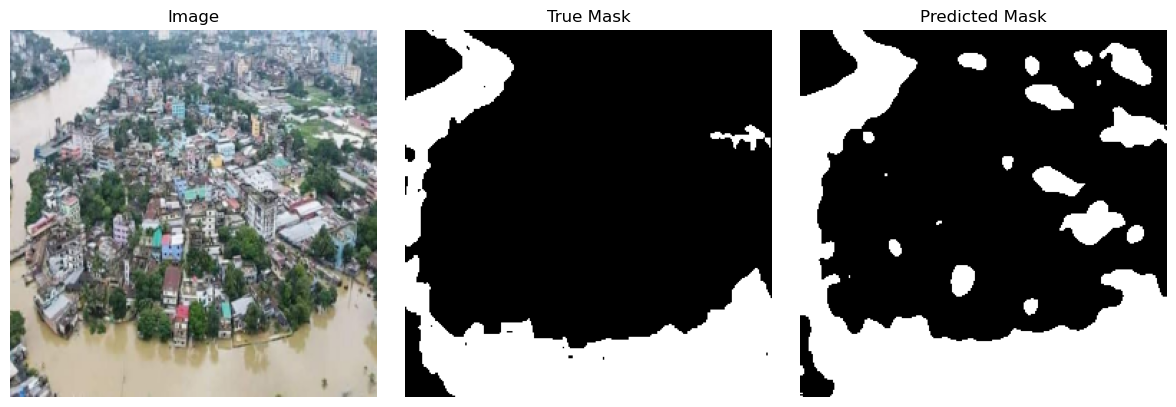

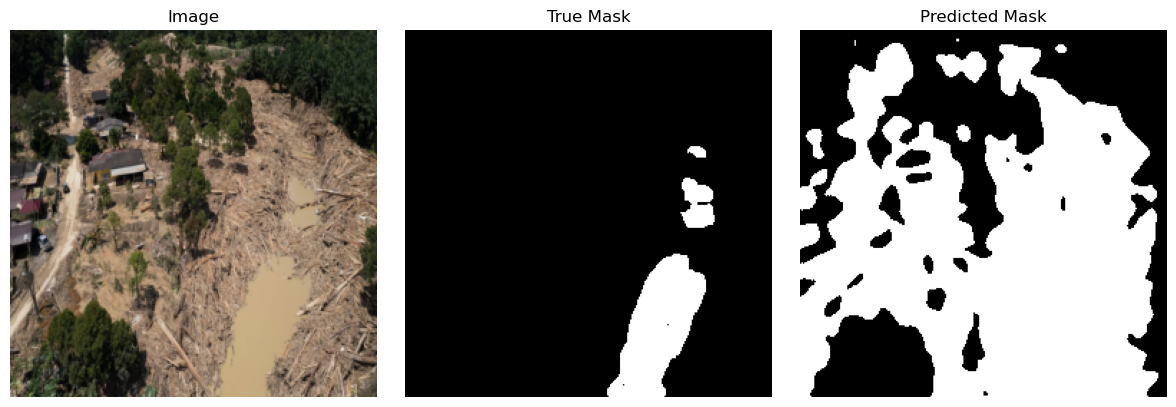

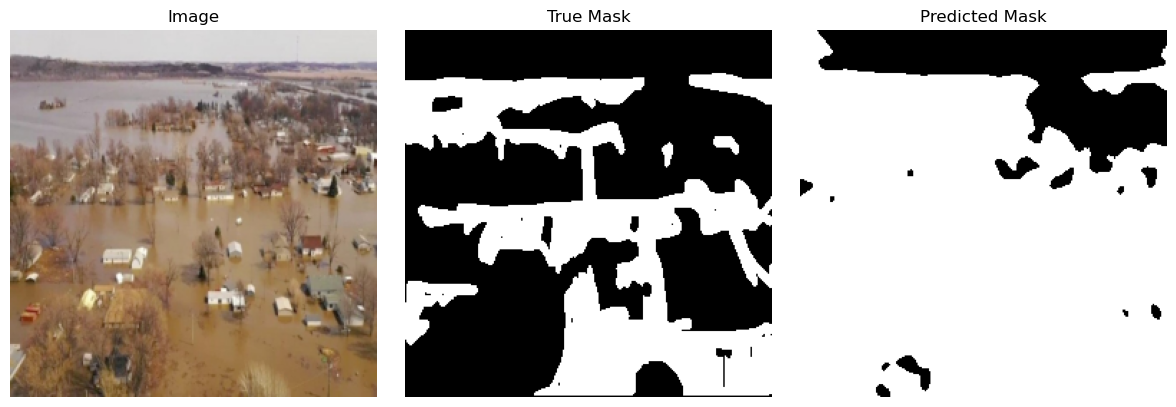

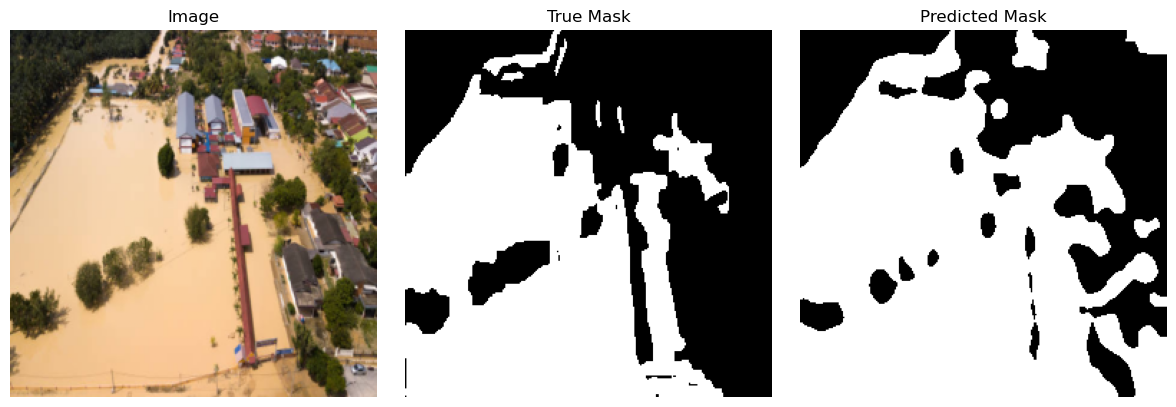

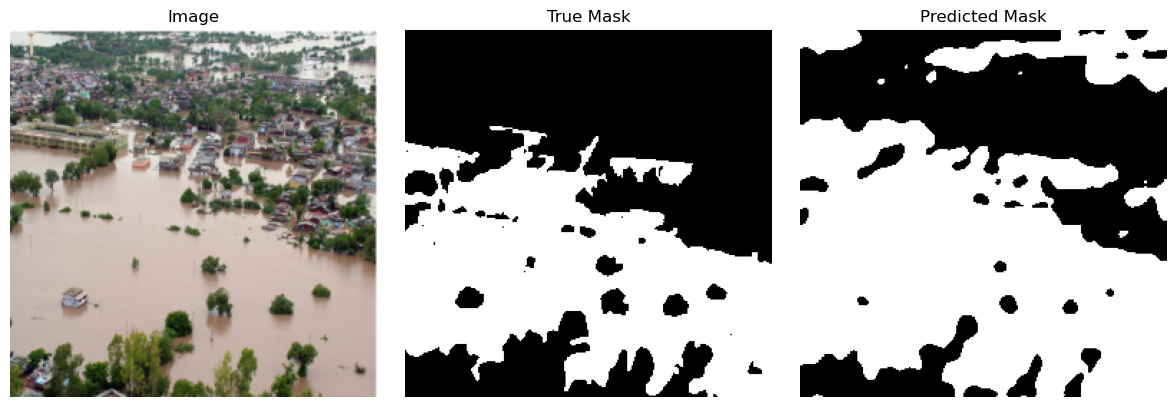

Epoch [2/50], Train Loss: 0.2101, Validation Loss: 0.1998
Epoch [3/50], Train Loss: 0.1959, Validation Loss: 0.1605
Epoch [4/50], Train Loss: 0.1713, Validation Loss: 0.1433
Epoch [5/50], Train Loss: 0.1562, Validation Loss: 0.1852
Epoch [6/50], Train Loss: 0.1598, Validation Loss: 0.1510
Epoch [7/50], Train Loss: 0.1505, Validation Loss: 0.1413
Epoch [8/50], Train Loss: 0.1492, Validation Loss: 0.1436
Epoch [9/50], Train Loss: 0.1392, Validation Loss: 0.1566
Epoch [10/50], Train Loss: 0.1402, Validation Loss: 0.1351
Epoch [11/50], Train Loss: 0.1234, Validation Loss: 0.1442
Epoch [12/50], Train Loss: 0.1242, Validation Loss: 0.2140
Epoch [13/50], Train Loss: 0.1266, Validation Loss: 0.1464
Epoch [14/50], Train Loss: 0.1144, Validation Loss: 0.1396
Epoch [15/50], Train Loss: 0.1033, Validation Loss: 0.1329
Epoch [16/50], Train Loss: 0.1046, Validation Loss: 0.1259
Epoch [17/50], Train Loss: 0.1029, Validation Loss: 0.1293
Epoch [18/50], Train Loss: 0.0946, Validation Loss: 0.1268
Epoch

<All keys matched successfully>

In [35]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4, oTBWriter = None):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []
    
    global_step_train = 0
    global_step_val = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Log train loss at each batch
            global_step_train += 1
            if oTBWriter is not None:
                oTBWriter.add_scalar('Train Loss', loss.item(), global_step_train)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.inference_mode():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Log validation loss at each batch
                global_step_val += 1
                if oTBWriter is not None:
                    oTBWriter.add_scalar('Validation Loss', loss.item(), global_step_val)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        #!!!
        if oTBWriter is not None:
            oTBWriter.add_scalar('Train Loss Epochs', avg_train_loss, epoch)
            oTBWriter.add_scalar('Validation Loss Epochs', avg_val_loss, epoch)
        #!!!

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Load the best model after training
        if(epoch == 1):
            plot_examples(model_unet_plus_plus, test_dataset, num_examples=5)

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model_UNET_plus_plus.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'unet++'))
train_model(model_unet_plus_plus, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, early_stop_patience=7, oTBWriter=oTBWriter)
oTBWriter.close()

# Load the best model after training
model_unet_plus_plus.load_state_dict(torch.load('best_model_UNET_plus_plus.pth'))

In [36]:
# # import torch
# # import torch.optim as optim
# # import segmentation_models_pytorch as smp
# # from torch.utils.data import DataLoader

# # Assuming you have defined your model, optimizer, criterion, and data loaders correctly

# def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         for batch_idx, (images, masks) in enumerate(train_loader):
#             images, masks = images.to(device), masks.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             if isinstance(outputs, tuple):
#                 outputs = outputs[0]
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# # Define your model, optimizer, and criterion
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model_unet_plus_plus = smp.UnetPlusPlus(...)  # Define your model here
# # model_unet_plus_plus = model_unet_plus_plus.to(device)
# optimizer = optim.Adam(model_unet_plus_plus.parameters(), lr=1e-3)
# criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

# # Assuming you have defined your train_loader correctly
# # train_loader = DataLoader(...)

# # Train the model
# train_model(model_unet_plus_plus, train_loader, criterion, optimizer, device, num_epochs=1)


## Plot Examples from Test Dataset

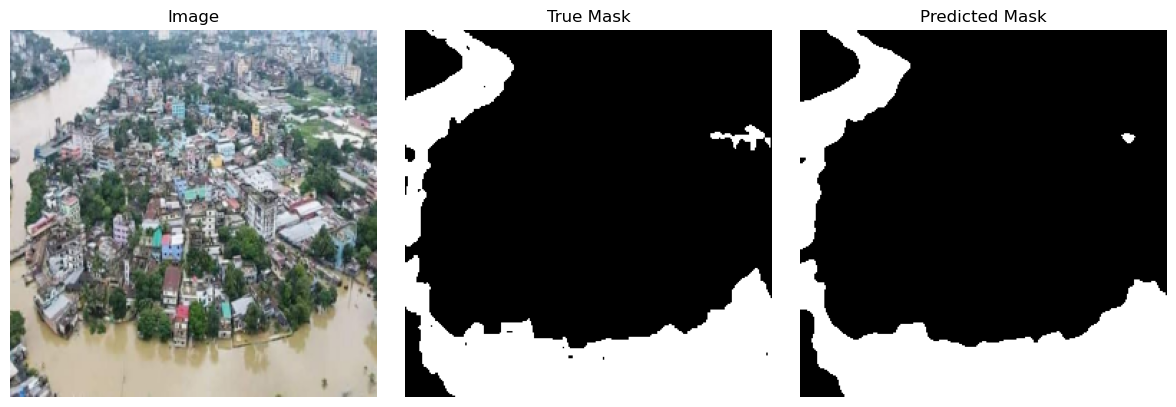

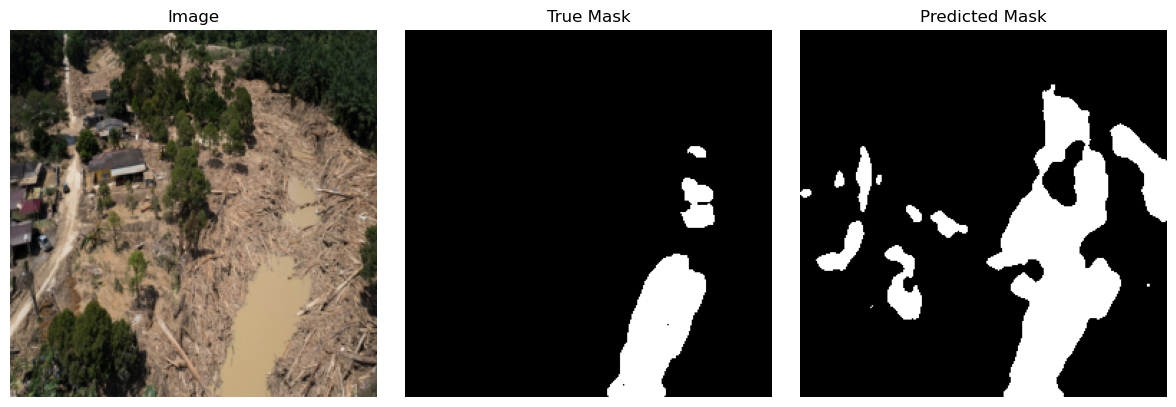

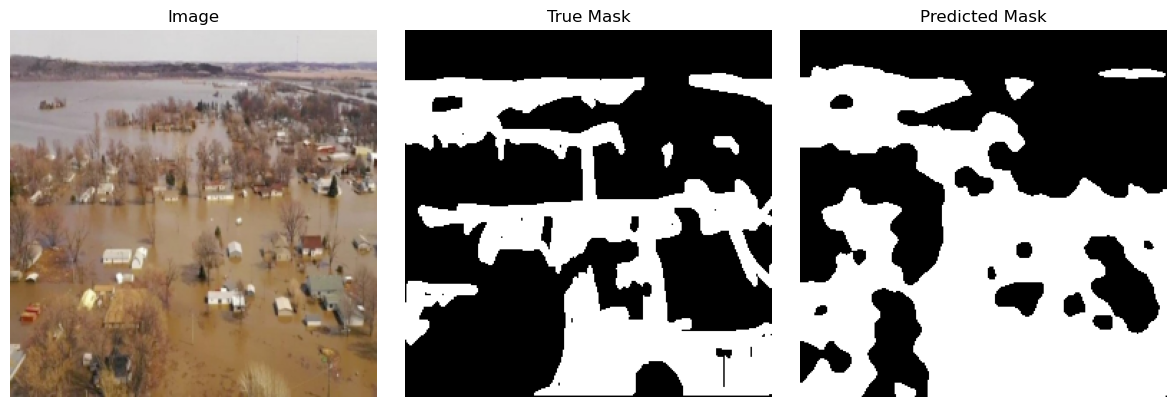

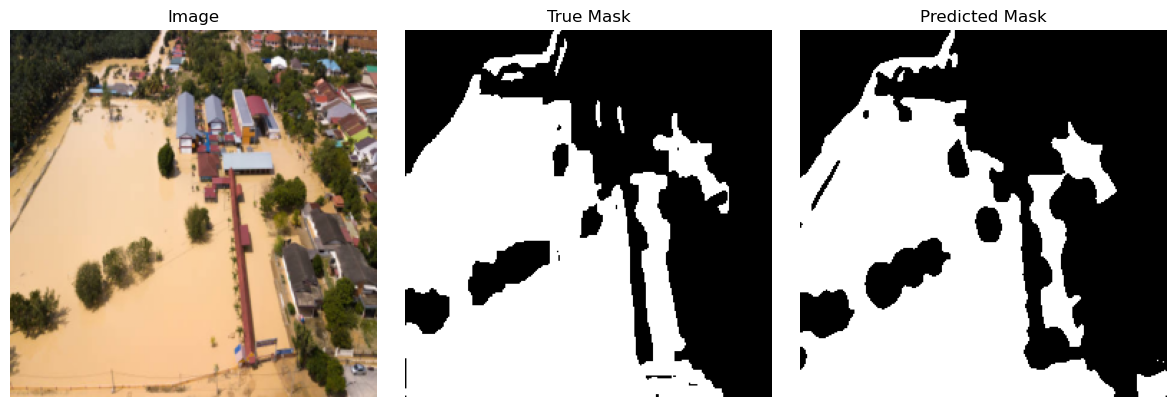

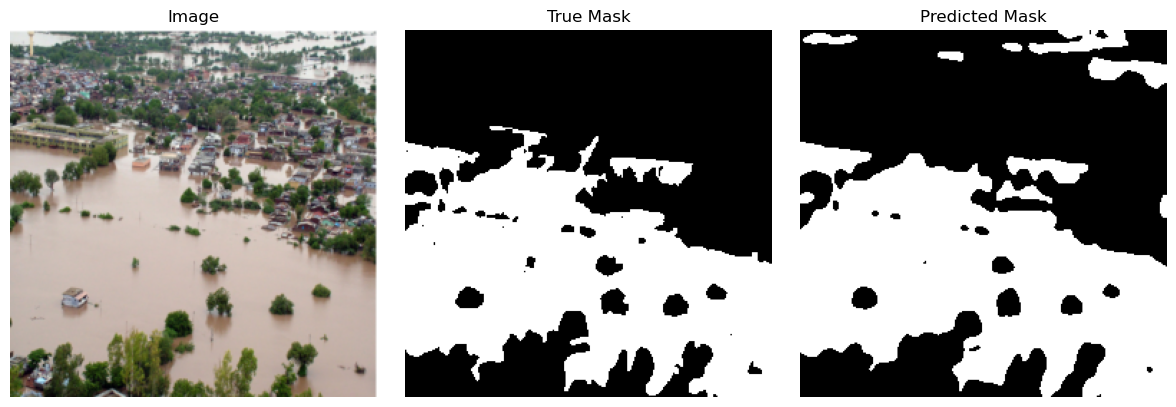

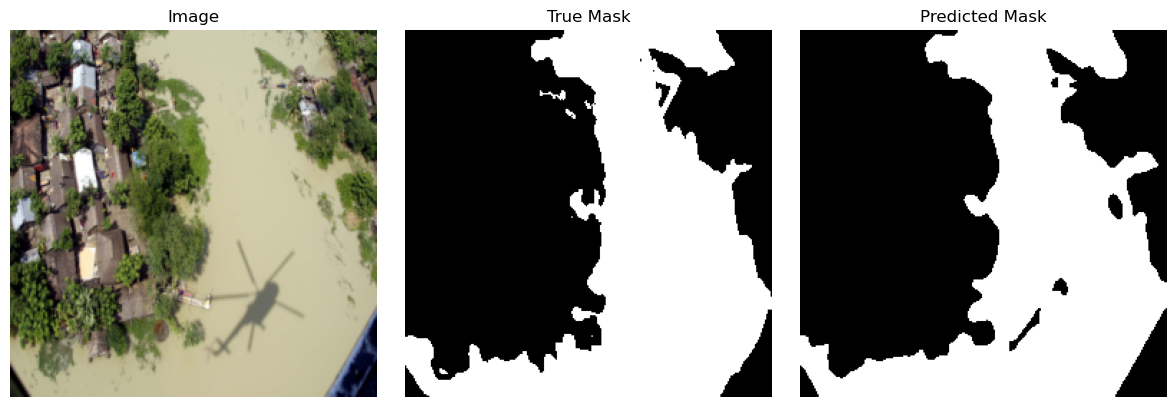

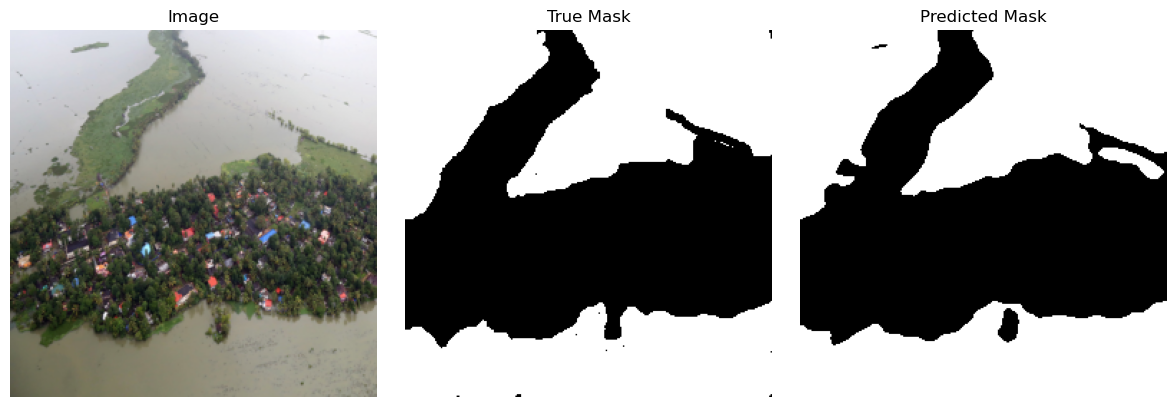

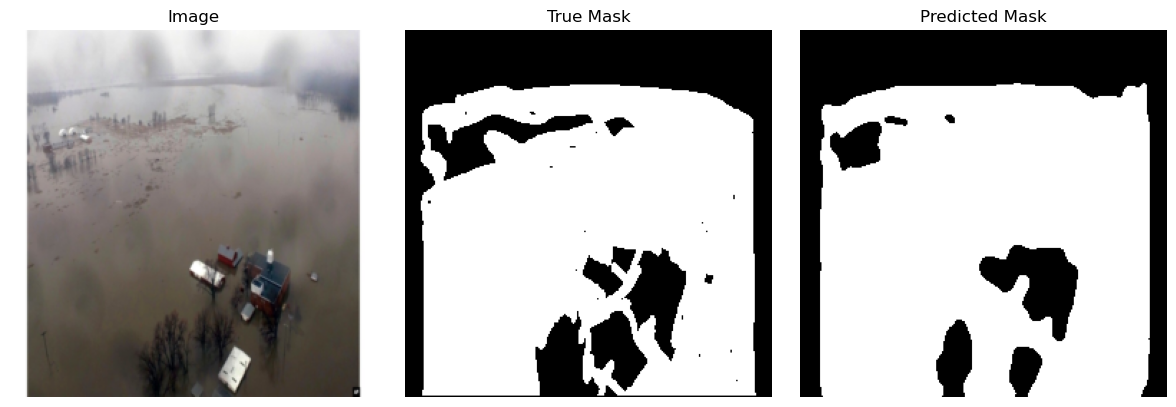

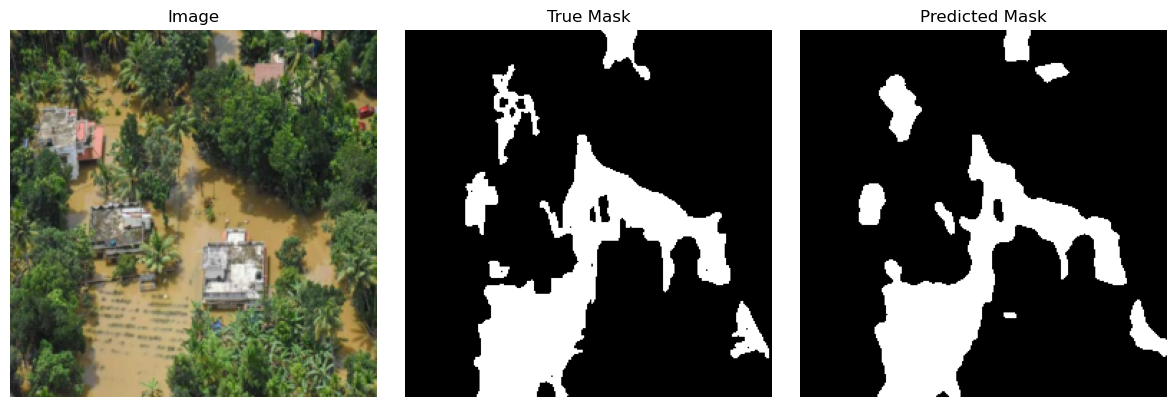

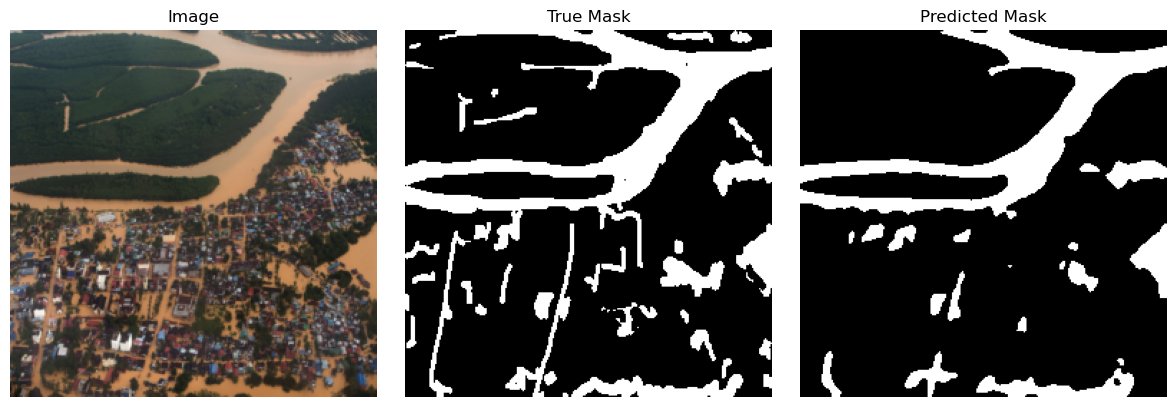

In [37]:
# Plot examples from the test dataloader
plot_examples(model_unet_plus_plus, test_dataset, num_examples=10)


## Compute metrics for test, train and validation datasets

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(device), masks.to(device)
        
        with torch.inference_mode():
            outputs = model(images)
        
        if isinstance(outputs, tuple):
            outputs = outputs[0].squeeze(0).to('cpu')
        # Convert probability maps to binary masks using a threshold
        probabilities = F.sigmoid(outputs)
        pred_masks = (probabilities > 0.5).float()  # Convert probabilities to binary mask
                
        true_masks_np = masks.cpu().detach().numpy()
        pred_masks_np = pred_masks.cpu().detach().numpy()
        
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(pred_masks_np)
    
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)
    
    # Flatten masks for binary classification
    all_true_masks_flat = all_true_masks.flatten()
    all_pred_masks_flat = all_pred_masks.flatten()

    # Calculate and print metrics
    accuracy  = accuracy_score(all_true_masks_flat, all_pred_masks_flat)
    jaccard   = jaccard_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    f1        = f1_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    precision = precision_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    recall    = recall_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Compute metrics for training set
print("Metrics for Training Set:")
compute_metrics(model_unet_plus_plus, train_loader)

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(model_unet_plus_plus, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(model_unet_plus_plus, test_loader)


Metrics for Training Set:


100%|██████████| 51/51 [00:07<00:00,  6.90it/s]


  Accuracy : 0.9441
  IoU      : 0.8944
  F1 Score : 0.9441
  Precision: 0.9441
  Recall   : 0.9441

Metrics for Validation Set:


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]


  Accuracy : 0.9057
  IoU      : 0.8285
  F1 Score : 0.9058
  Precision: 0.9058
  Recall   : 0.9057

Metrics for Test Set:


100%|██████████| 11/11 [00:01<00:00,  6.80it/s]


  Accuracy : 0.9034
  IoU      : 0.8245
  F1 Score : 0.9035
  Precision: 0.9036
  Recall   : 0.9034
